# DC Motor Simulation

Look at the dynamics_model.pdf for the explanation behind this code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

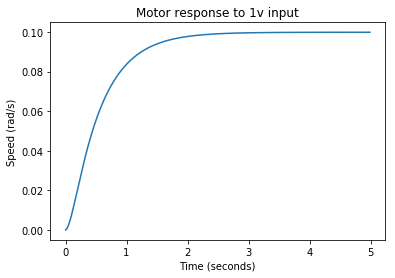

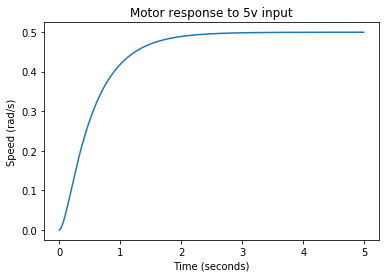

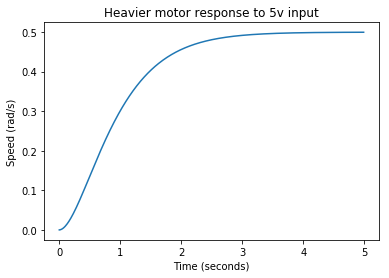

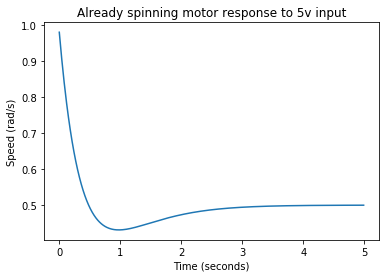

In [2]:
def simulate(V, J, C, K, R, L, theta_dot=0, i=0):
    # simulate T seconds
    T = 5
    dt = 0.01
    ts = np.arange(0, T, dt)
    theta_dots = np.zeros(ts.shape[0])
    currents = np.zeros(ts.shape[0])
    for idx, t in enumerate(ts):
        A = np.array([[-C/J,K/J],[-K/L,-R/L]])
        B = np.array([0, 1/L])
        x = np.array([theta_dot, i])
        w = V(t, i, theta_dot)
        x_dot = A@x+B*w
#         print(x_dot, theta_dot, i)
        theta_dot += (x_dot[0] * dt)
        i += (x_dot[1] * dt)
        theta_dots[idx] = theta_dot
        currents[idx] = i
    
    return ts, theta_dots, currents

def const_V(v):
    def _v(t, i, theta_dot):
        return v
    return _v

ts, theta_dots, _ = simulate(const_V(1), J=0.01, C=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Motor response to 1v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots, _ = simulate(const_V(5), J=0.01, C=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots, _ = simulate(const_V(5), J=0.05, C=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Heavier motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots, _ = simulate(const_V(5), J=0.05, C=0.1, K=0.01, R=1, L=0.5, theta_dot=1)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Already spinning motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

plt.show()

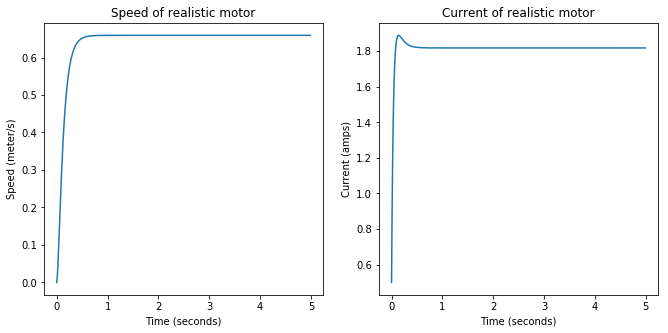

In [3]:
ts, theta_dots, currents = simulate(const_V(5), J=0.00005, C=0.0004, K=0.01, R=2.5, L=0.1)

plt.figure(figsize=(11,5))
plt.subplot(121)
plt.plot(ts, theta_dots * 0.0145)
plt.title("Speed of realistic motor")
plt.ylabel("Speed (meter/s)")
plt.xlabel("Time (seconds)")

plt.subplot(122)
plt.plot(ts, currents)
plt.title("Current of realistic motor")
plt.ylabel("Current (amps)")
plt.xlabel("Time (seconds)")
plt.show()

we can use the slope of this line as our feed forward slope
We just need to convert from $\frac{v}{m*s^{-1}}$ to $\frac{f}{rad*s^{-1}}$

$$ \frac{\text{volts}}{m*s^{-1}}*\frac{255\text{ abstract force}}{5\text{ volts}}*\frac{0.0145\text{ meters}}{\text{radians}} $$

The invert this value.

## Wheel inertia calculation

$$ I_z = \frac{mr^2}{2} = \frac{0.0122*0.014^2}{2} = 0.0000011956 $$

\*source for mass & radius: https://www.pololu.com/product/1127

# Solving IVP for DC Motor Model

The following differential equation describes our dc motor model

$$ \frac{K}{LJ}u = \ddot{y} + \bigg(\frac{C}{J} + \frac{RJ}{L}\bigg)\dot{y} + \bigg(\frac{RC}{LJ} + \frac{K^2}{LJ}\bigg)y $$

First find the generic solution to the homogeneous form:

$$ 0 = \ddot{y} + \bigg(\frac{C}{J} + \frac{RJ}{L}\bigg)\dot{y} + \bigg(\frac{RC}{LJ} + \frac{K^2}{LJ}\bigg)y $$

If we plug in the following coefficients

| Var | Value        |
|-----|--------------|
|   J | 0.000658     |
|   C | 0.0000024571 |
|   K | 0.0787       |
|   R | 5            |
|   L | 0.58         |

The following code calculates the roots

In [5]:
J = 0.000658
C = 0.0000012615 + 0.0000011956
K = 0.0787
R = 5
L = 0.58

a = 1
b = C/J+R/L
c = R*C/(L*J) + K**2/(L*J)
print(a, b, c)

root_1 = (-b + np.sqrt(b**2-4*a*c))/2
root_2 = (-b - np.sqrt(b**2-4*a*c))/2
print("characteristic roots:")
print(root_1)
print(root_2)

1 8.62442384970129 16.261333979666706
characteristic roots:
-2.7845216076863966
-5.839902242014894


These roots then give us the general form of our solution:

$$ y(x) = c_1e^{-2.7845x} + c_2e^{-5.8399x} $$

If we have an initial speed an velocity $y(0) = y_0$ and $\dot{y}(0) = \dot{y}_0$ we can solve for $c_1$ and $c_2$. Remember, $y$ here is wheel angle, so this means we just need our initial angle and velocity. Let's do an example where $y_0 = 0m$ and $\dot{y}_0 = 0.2m/s$

\begin{align*}
  0 &= c_1e^{-2.7845(0)} + c_2e^{-5.8399(0)} \\
  0  &= c_1 + c_2 \\
  c_1  &= -c_2 \\
  \dot{y}(x) &= -2.7845c_1e^{-2.7845x} + -5.8399c_2e^{-5.8399x} \\
  0.2 &= -2.7845c_1e^{-2.7845(0)} + -5.8399c_2e^{-5.8399(0)} \\
  0.2 &= -2.7845c_1 + -5.8399c_2 \\
  0.2 &= -2.7845(-c_2) + -5.8399c_2 \\
  0.2 &= (2.7845 + -5.8399)c_2 \\
  0.2 &= -3.0554c_2 \\
  -0.06546 &= c_2 \\
  0.06546 &= c_1
\end{align*}

We how need a particular solution.

In [6]:
print("for u=5 volts")
u=5
f = K/(L*J)*u
print("forcing term = ", f)

for u=5 volts
forcing term =  1031.0764070852115


A particular solution will satisfy this equation:

$$ 1031.0764 = \ddot{y} + 8.6244\dot{y} + 16.2613y $$

We should suspect this has a constant solution A, so we can solve for that like so
$$\begin{align*}
    1031.0764 &= (0) + 8.6244(1) + 16.2613A \\
    1031.0764 &= 8.6244 + 16.2613A \\
    A &= \frac{1031.0764 - 8.6244}{16.2613} \\
    A &= 1022.4519
\end{align*}$$

In [7]:
print("A = ", (f - b)/a)
y_particular = (f - b)/a

A =  1022.4519832355102


This means our end result specific solution is

$$ y(x) = c_1e^{-2.7845x} + c_2e^{-5.8399x}  + 1022.4520 $$

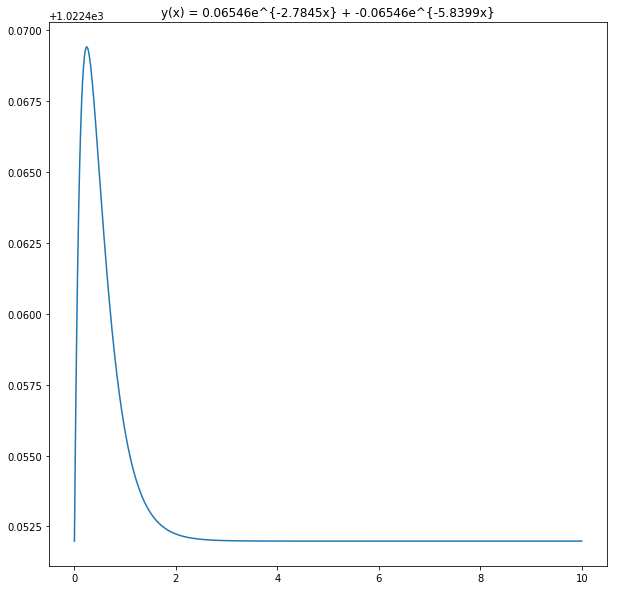

In [8]:
x = np.linspace(0, 10, 1000)
u = 5
y = 0.06546*np.exp(-2.7845*x) + -0.06546*np.exp(-5.8399*x) + y_particular

plt.figure(figsize=(10,10))
plt.plot(x, y)
plt.title("y(x) = 0.06546e^{-2.7845x} + -0.06546e^{-5.8399x}")
plt.show()